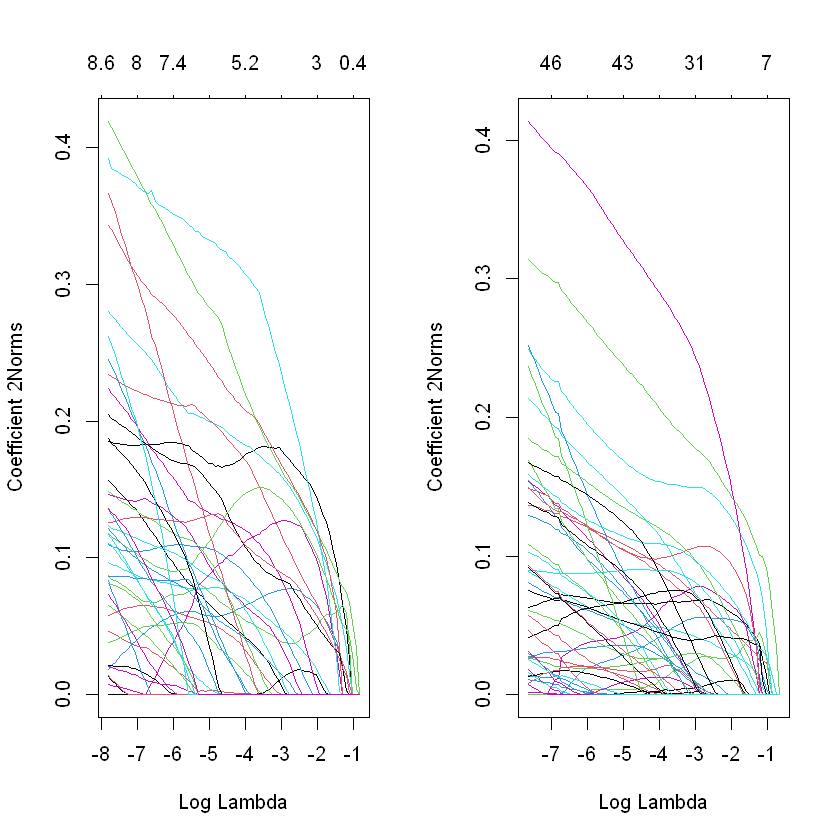

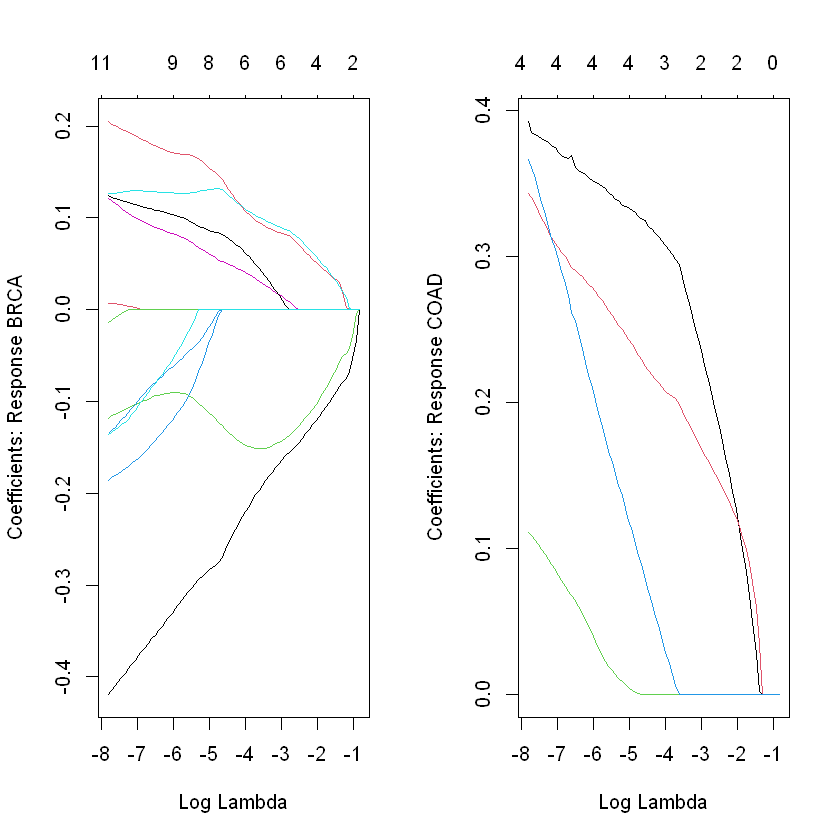

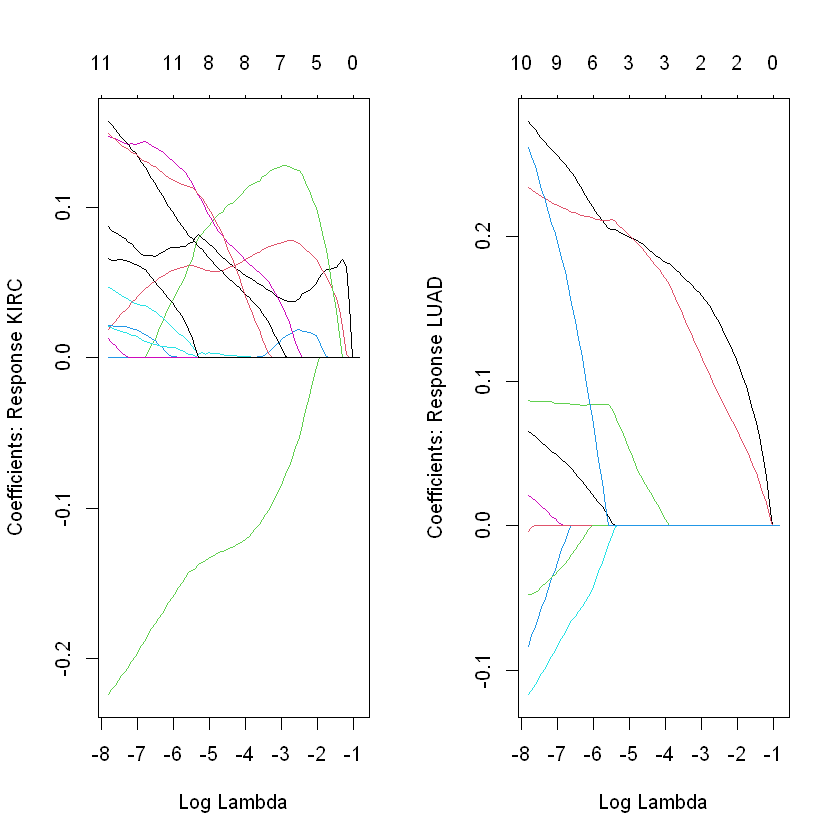

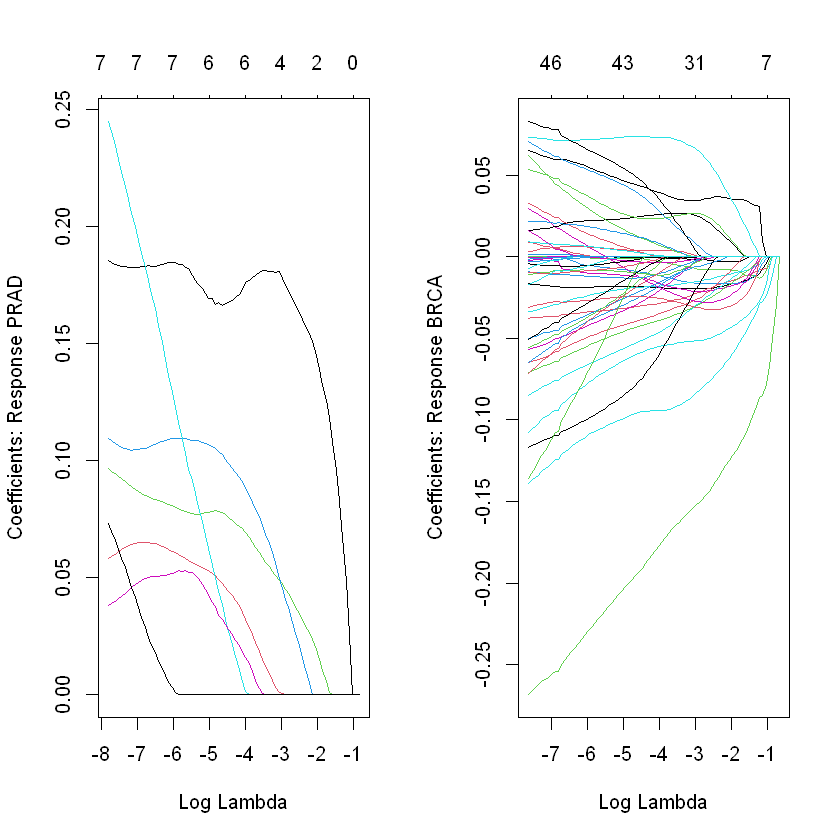

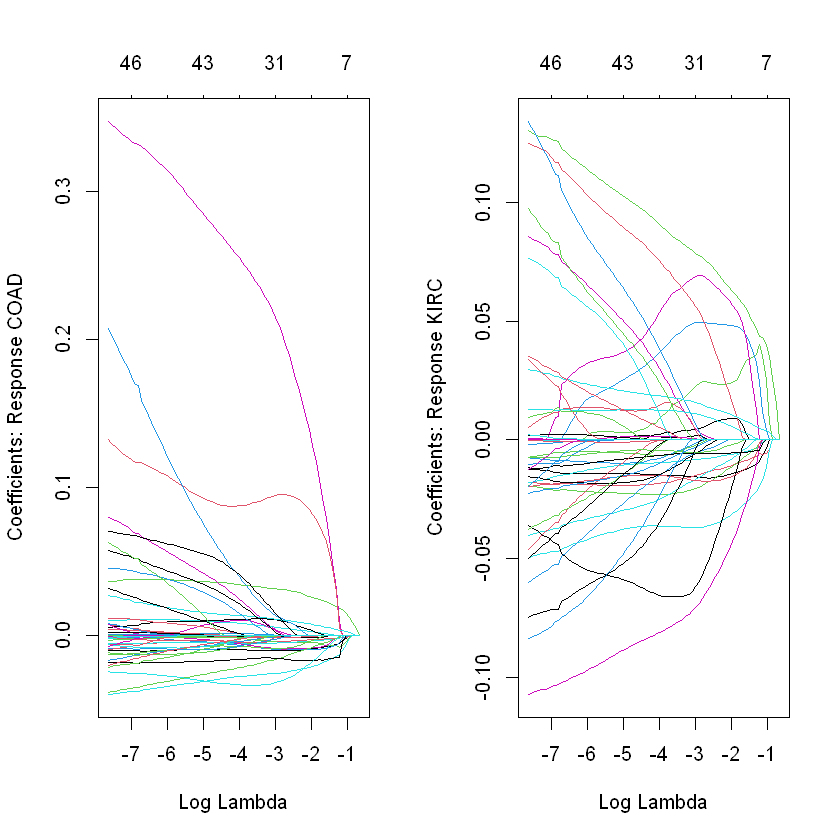

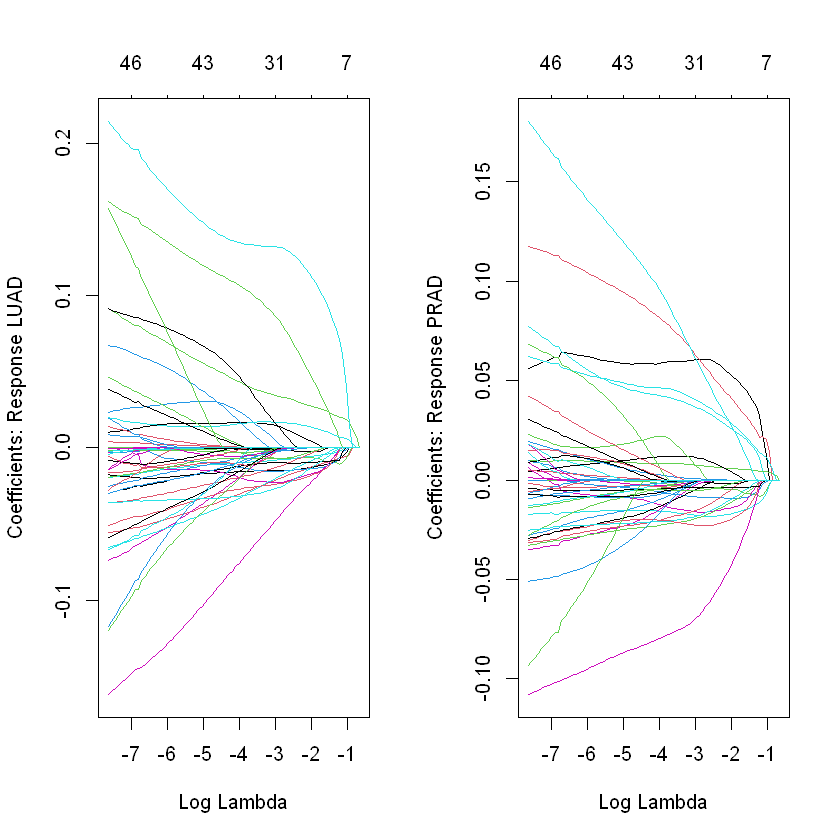

1
PRAD
LUAD
PRAD
PRAD
BRCA
PRAD
KIRC
PRAD
BRCA
PRAD


1
PRAD
LUAD
PRAD
PRAD
BRCA
PRAD
KIRC
PRAD
BRCA
PRAD


1
PRAD
LUAD
PRAD
PRAD
BRCA
PRAD
KIRC
PRAD
BRCA
PRAD


1
PRAD
LUAD
PRAD
PRAD
BRCA
PRAD
KIRC
PRAD
BRCA
PRAD


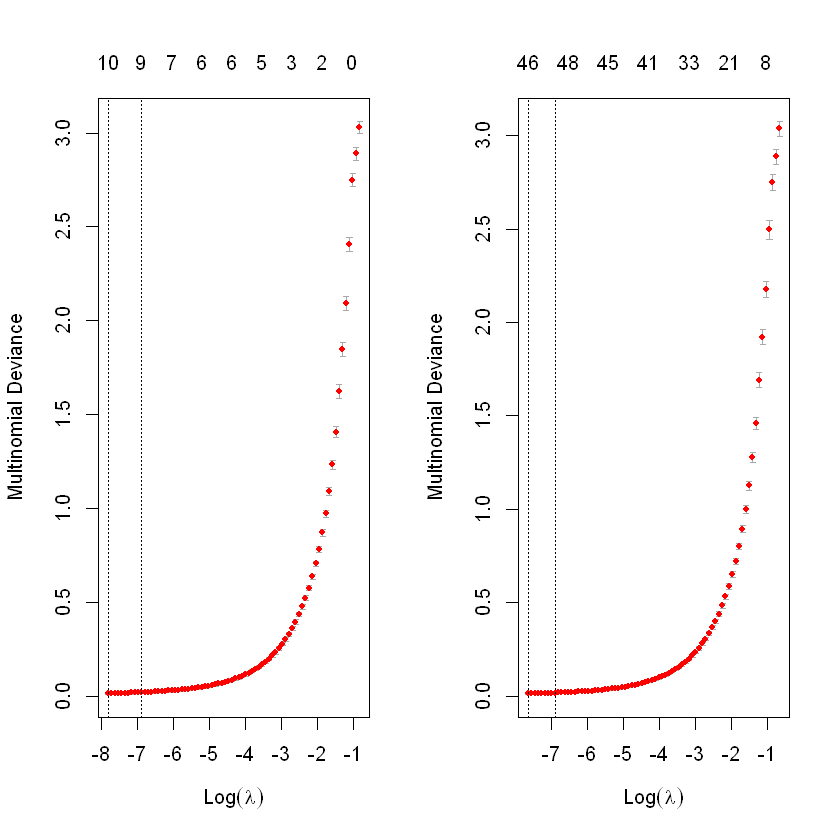

In [18]:
cbPalette <- c(
  "#999999", "#E69F00", "#56B4E9", "#009E73",
  "#F0E442", "#0072B2", "#D55E00", "#CC79A7") # colour-blind friendly palette




# loading dataset 
data <- as_tibble(read.csv("data.csv",
                           header = TRUE,
                           row.names = 1))


labels <- as_tibble(read.csv("labels.csv",
                             header = TRUE,
                             row.names = 1))

## ---- Filtering using F-statistic --------------------------------------------
library(readr)
library("ggplot2")
library("dplyr")
library("tidyr")
library("stringr")
#library("purr")
library("forcats")
library("grDevices")
library("data.table")
library("tidyverse")
library("latex2exp")
library("irlba") 
library("plot3D")
library("rgl")

# remove all constant features
data.no.const <- as.matrix(data[, apply(data, 2, var) > 0]) 


# Make labels into matrix instead
lab <- as.matrix(labels)

# Calculate F-value for each gene
F.value <- apply(data.no.const, 2, function(x) anova(lm(x ~ lab))$'F value'[1])

# Extract 200 genes with top F-value (most informative)
data.filtered <- data.no.const[, order(F.value, decreasing = TRUE)[1:200]]

library(glmnet)

# Create multiclass logistic models with glmnet

mod.multi <- glmnet(
  x = data.filtered, y = lab,
  family = "multinomial",
  #type.multinomial = "grouped"
)


mod.multi.group <- glmnet(
  x = data.filtered, y = lab,
  family = "multinomial",
  type.multinomial = "grouped"
)

# type.multinomial allows the usage of grouped lasso 
# penalty if you specify "grouped"




# Plot figure with l2 norm and penalty
par(mfrow = c(1,2))

plot(mod.multi, 
     xvar = "lambda", 
     label = TRUE,
     type.coef = "2norm")


plot(mod.multi.group, 
     xvar = "lambda", 
     label = TRUE,
     type.coef = "2norm")


# Plot figure with coef and penalty
par(mfrow = c(1,2))

plot(mod.multi, 
     xvar = "lambda", 
     label = TRUE,
     type.coef = "coef")


plot(mod.multi.group, 
     xvar = "lambda", 
     label = TRUE,
     type.coef = "coef")

# Cross-validaton for both grouped case and ungrouped

cv.multi <- cv.glmnet(data.filtered, lab, family = "multinomial")

cv.multi.group <- cv.glmnet(data.filtered, lab, family = "multinomial", 
                            type.multinomial = "grouped")

# Plot the deviance against log(lambda)
par(mfrow = c(1,2))

plot(cv.multi)

plot(cv.multi.group)

# Predict optimal selected lambda:

predict(cv.multi, newx = data.filtered[1:10,], s = "lambda.min", type = "class")

predict(cv.multi.group, newx = data.filtered[1:10,], s = "lambda.min", type = "class")

predict(cv.multi, newx = data.filtered[1:10,], s = "lambda.1se", type = "class")

predict(cv.multi.group,  newx = data.filtered[1:10,], s = "lambda.min", type = "class")


# Convert to matrix for each class

coef.BRCA <- as.matrix(coef(cv.multi)$"BRCA")
coef.LUAD <- as.matrix(coef(cv.multi)$"LUAD")
coef.KIRC <- as.matrix(coef(cv.multi)$"KIRC")
coef.PRAD <- as.matrix(coef(cv.multi)$"PRAD")
coef.COAD <- as.matrix(coef(cv.multi)$"COAD")


non.zero.coef.BRCA <- coef.BRCA[coef.BRCA != 0,]
non.zero.coef.LUAD <- coef.LUAD[coef.LUAD != 0,]
non.zero.coef.KIRC <- coef.KIRC[coef.KIRC != 0,]
non.zero.coef.PRAD <- coef.PRAD[coef.PRAD != 0,]
non.zero.coef.COAD <- coef.COAD[coef.COAD != 0,]

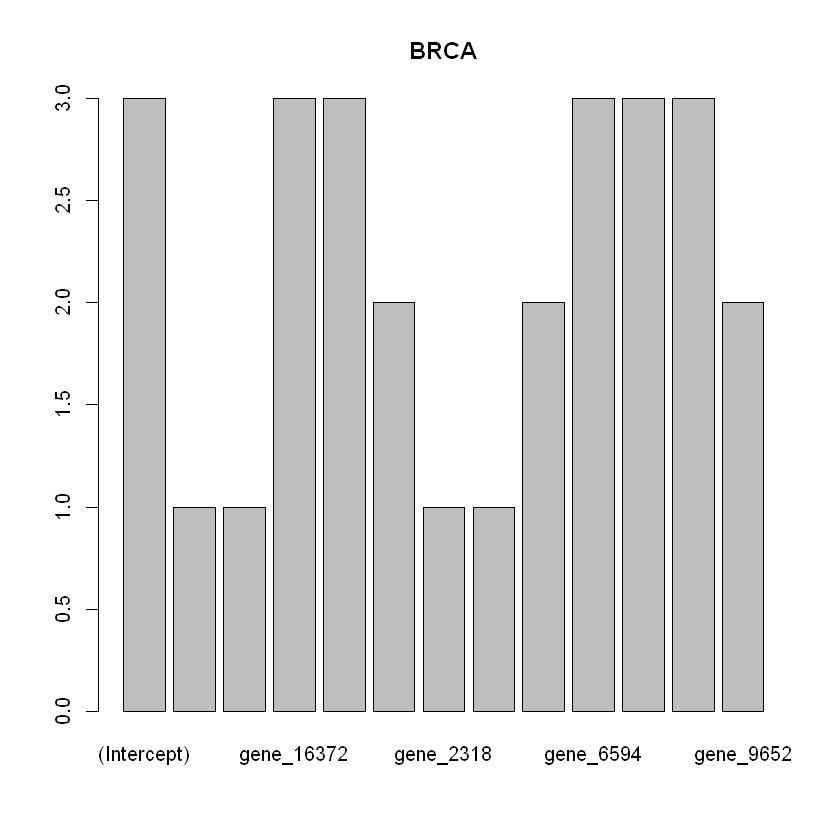

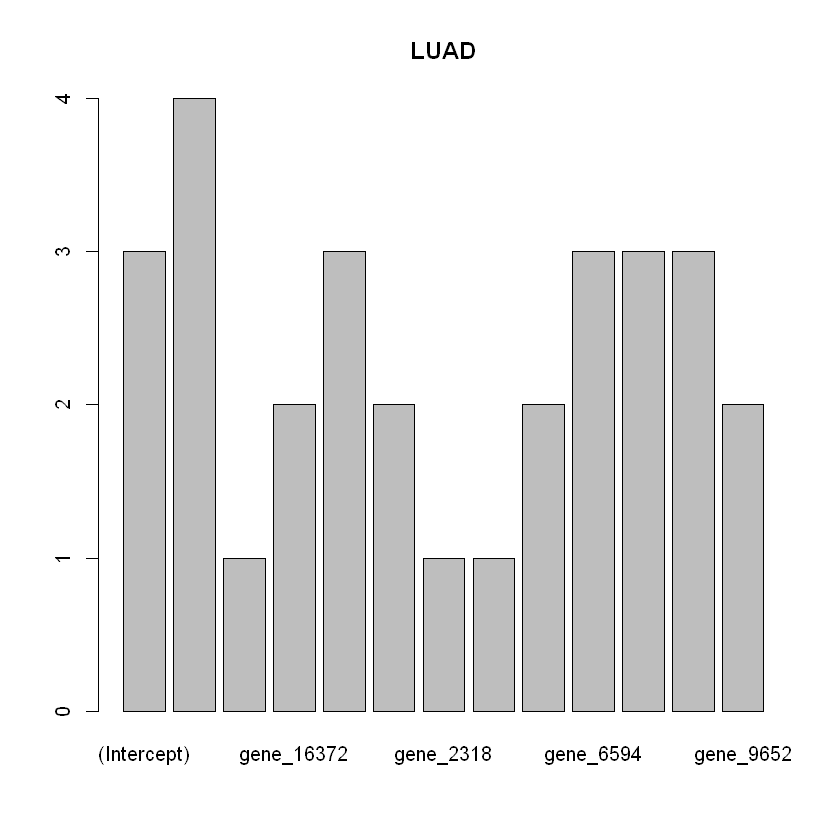

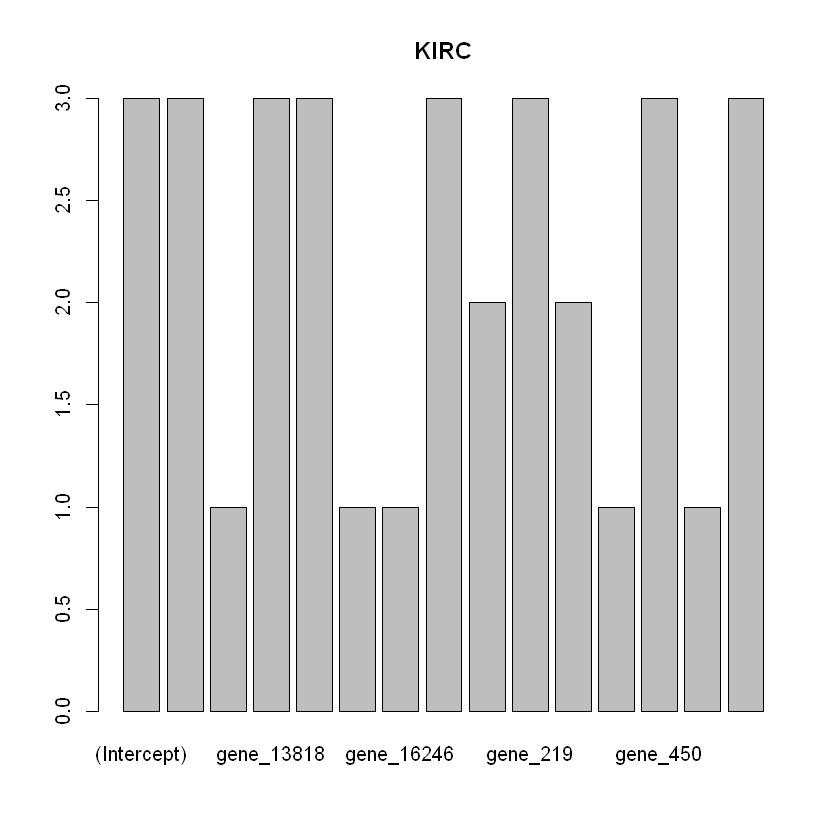

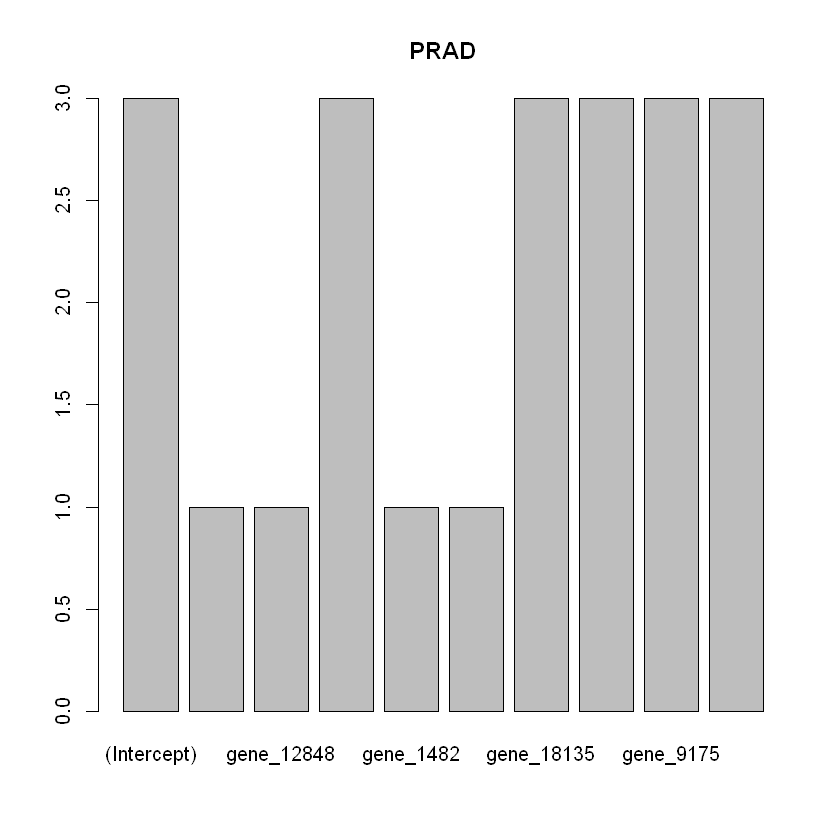

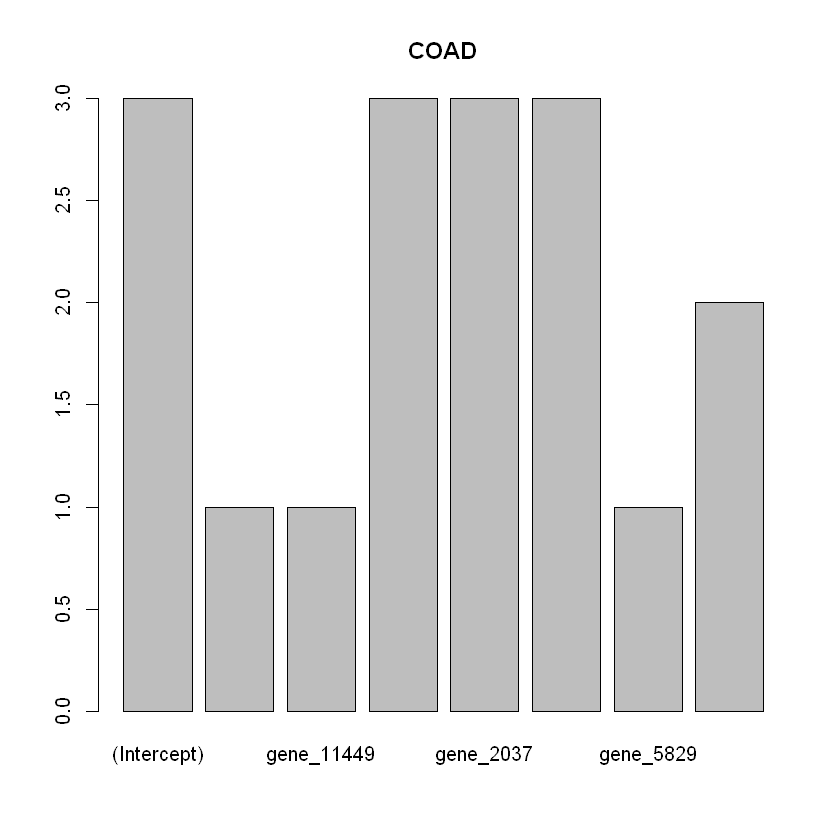

In [23]:

M  = 3



boot.data.X <- matrix(0, nrow = 801, ncol = 200)
boot.lab.y <- matrix(0, nrow = 801, ncol = 1)

# Record how often each feature got selected for each class across bootstrap samples. 
# You will essentially get a histogram where larger peaks indicate that a feature was chosen more often.


# Initiate vector for labels (nrow is arbitrary number < M)
labels.BRCA <- matrix(0, nrow = 100, ncol = M)
labels.LUAD <- matrix(0, nrow = 100, ncol = M)
labels.KIRC <- matrix(0, nrow = 100, ncol = M)
labels.PRAD <- matrix(0, nrow = 100, ncol = M)
labels.COAD <- matrix(0, nrow = 100, ncol = M)


# Loop to create M bootstrap models
for ( i in 1:M) {
  
  # The bootstrapped data (replace = T is important!)
  #boot.data <- data.filtered[,sample(ncol(data.filtered), size = 200, replace = TRUE)]
  
    # Row id for bootstrapping
  id <- sample(801, size = 801, replace = T)

   # Bootstrapped data and labels
    boot.data.X <- data.filtered[id,]
    boot.lab.y <- lab[id,]
    
  # Create model for bootstrapped data
  mod <- glmnet(
    x = boot.data.X, y = boot.lab.y,
    family = "multinomial")
  
  # Cross-validate bootstrapped data
  cv.mod <- cv.glmnet(boot.data.X, boot.lab.y, family = "multinomial")
  
  
  # Extract the coef for each class
  coef.BRCA <- as.matrix(coef(cv.mod)$"BRCA")
  coef.LUAD <- as.matrix(coef(cv.mod)$"LUAD")
  coef.KIRC <- as.matrix(coef(cv.mod)$"KIRC")
  coef.PRAD <- as.matrix(coef(cv.mod)$"PRAD")
  coef.COAD <- as.matrix(coef(cv.mod)$"COAD")
  
  # If you want to use function:
  # non.zero.coef <- function(x){
  #   
  #   # x is the respective coef matrix for each class
  #   
  #   
  #   return <- x[x != 0,]
  #   
  # }
  
  # Extract the non-zero coef for each class
  non.zero.coef.BRCA <- coef.BRCA[coef.BRCA != 0,]
  non.zero.coef.LUAD <- coef.LUAD[coef.LUAD != 0,]
  non.zero.coef.KIRC <- coef.KIRC[coef.KIRC != 0,]
  non.zero.coef.PRAD <- coef.PRAD[coef.PRAD != 0,]
  non.zero.coef.COAD <- coef.COAD[coef.COAD != 0,]
  
  
  # Insert the names of the respective genes which have non-zero coef
  labels.BRCA[c(1:length(non.zero.coef.BRCA)),i] <- labels(non.zero.coef.BRCA)
  
  labels.LUAD[c(1:length(non.zero.coef.LUAD)),i] <- labels(non.zero.coef.LUAD)
  
  labels.KIRC[c(1:length(non.zero.coef.KIRC)),i] <- labels(non.zero.coef.KIRC)
  
  labels.PRAD[c(1:length(non.zero.coef.PRAD)),i] <- labels(non.zero.coef.PRAD)
  
  labels.COAD[c(1:length(non.zero.coef.COAD)),i] <- labels(non.zero.coef.COAD)
  
}

# Barplot for the genes with non-zero coef (to see freq over M)
all.genes.BRCA <- labels.BRCA[labels.BRCA != 0]

barplot(table(all.genes.BRCA), main = "BRCA")

all.genes.LUAD <- labels.BRCA[labels.LUAD != 0]

barplot(table(all.genes.LUAD), main = "LUAD")

all.genes.KIRC <- labels.KIRC[labels.KIRC != 0]

barplot(table(all.genes.KIRC), main = "KIRC")

all.genes.PRAD <- labels.PRAD[labels.PRAD != 0]

barplot(table(all.genes.PRAD), main = "PRAD")

all.genes.COAD <- labels.COAD[labels.COAD != 0]

barplot(table(all.genes.COAD), main = "COAD")





